In [15]:
from collections import deque
import yfinance as yf
import pandas as pd
import numpy as np

In [16]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [17]:
class Environment:
 
  def __init__(self, data, window_size=90, initial_balance=10000):
    self.data = data
    self.window_size = window_size
    self.initial_balance = initial_balance
    self.reset()

  def reset(self):
    self.balance = self.initial_balance
    self.shares_held = 0
    self.cost_price = 0  # Track buying price for calculating ROI
    self.state = deque(maxlen=self.window_size)
    self.history = self.data.iloc[:self.window_size]  # Initial window of data
    self.current_step = self.window_size  # Start after initial window

    # Fill initial state with normalized prices
    for i in range(self.window_size):
      close_price = self.history.iloc[i]['Close']
      self.state.append((close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])

    return self._get_obs()

  def _get_obs(self):
    return np.array(self.state)

  def step(self, action):
    # Handle actions (0: hold, 1: buy, 2: sell)
    if action == 0:
      pass  # Hold
    elif action == 1:
      if self.balance >= self.data.iloc[self.current_step]['Close'] and self.shares_held == 0:
        self.balance -= self.data.iloc[self.current_step]['Close']
        self.shares_held = 1
        self.cost_price = self.data.iloc[self.current_step]['Close']  # Update cost price
    elif action == 2:
      if self.shares_held > 0:
        self.balance += self.shares_held * self.data.iloc[self.current_step]['Close']
        self.shares_held = 0
        self.cost_price = 0  # Reset cost price after selling

    # Update state and reward
    next_close_price = self.data.iloc[self.current_step]['Close']
    reward = 0
    if self.shares_held > 0:
      reward = (next_close_price - self.cost_price) / self.cost_price  # Calculate ROI as reward
    self.state.append((next_close_price - self.history.iloc[0]['Close']) / self.history.iloc[0]['Close'])  # Update state
    self.history = pd.concat([self.history, self.data.iloc[self.current_step].to_frame().T])
    self.current_step += 1

    done = self.current_step >= len(self.data)
    return self._get_obs(), reward, done

In [18]:
class QLearningAgent:
  def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
    self.q_table = {}
    self.actions = actions
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma

  def choose_action(self, state):
    if np.random.uniform(0, 1) < self.epsilon:
      action = np.random.choice(self.actions)
    else:
      if tuple(state) not in self.q_table:
        self.q_table[tuple(state)] = np.zeros(len(self.actions))
      action = self.actions[np.argmax(self.q_table[tuple(state)])]
    return action

  def update_q_table(self, state, action, reward, next_state):
    if tuple(state) not in self.q_table:
      self.q_table[tuple(state)] = np.zeros(len(self.actions))

In [19]:
data = download_data("AAPL", "2010-01-01", "2023-12-31")

# Define training parameters
window_size = 90
initial_balance = 10000
num_episodes = 1000
epsilon = 0.1
alpha = 0.2
gamma = 0.9

# Create environment and agent
actions = [0, 1, 2]  # 0: hold, 1: buy, 2: sell
env = Environment(data, window_size, initial_balance)
agent = QLearningAgent(actions, epsilon, alpha, gamma)

# Training loop
episode_rewards = []  # Track episode rewards for evaluation
for episode in range(num_episodes):
  state = env.reset()
  done = False
  episode_reward = 0
  
  while not done:
    action = agent.choose_action(state)
    next_state, reward, done = env.step(action)
    episode_reward += reward
    agent.update_q_table(state, action, reward, next_state)
    state = next_state

  episode_rewards.append(episode_reward)
  print(f"Episode: {episode+1} | Total Reward: {episode_reward}")


[*********************100%%**********************]  1 of 1 completed


Episode: 1 | Total Reward: 97.4003550565175
Episode: 2 | Total Reward: 44.18394102564095
Episode: 3 | Total Reward: 105.0696964342962
Episode: 4 | Total Reward: 35.24214177978296
Episode: 5 | Total Reward: 33.66015730591911
Episode: 6 | Total Reward: 45.245541274425285
Episode: 7 | Total Reward: 30.389894882375522
Episode: 8 | Total Reward: 36.454059356855154
Episode: 9 | Total Reward: 99.63783407213836
Episode: 10 | Total Reward: 50.384033510436524
Episode: 11 | Total Reward: 91.69974587150153
Episode: 12 | Total Reward: 36.54136821753203
Episode: 13 | Total Reward: 38.456156856916294
Episode: 14 | Total Reward: 40.426020371661124
Episode: 15 | Total Reward: 153.42971538816332
Episode: 16 | Total Reward: 53.92208958959585
Episode: 17 | Total Reward: 50.72496261518404
Episode: 18 | Total Reward: 23.388130539621518
Episode: 19 | Total Reward: 50.98670017350297
Episode: 20 | Total Reward: 1.5341488300649535
Episode: 21 | Total Reward: 44.7114168317877
Episode: 22 | Total Reward: 39.37112

In [ ]:
import matplotlib as plt

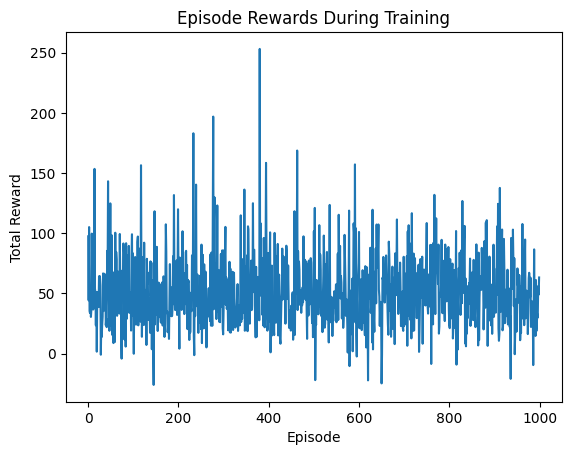

In [20]:

# Plot episode rewards
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Rewards During Training")
plt.show()